In [72]:
# Compute uvgeo from SSH
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import sys

import xarray as xr
import numpy as np
import sys
import hydra
from typing import Optional
import datetime


ATTRS ={'time': {'dtype': 'int64',}, # 'units': 'days since 2019-01-01', }, 
        'lon': {'dtype': 'float32', 'valid_min': -180., 'valid_max': 180.,
                'long_name': 'longitude', 'standard_name': 'longitude',
                'units': 'degrees_east'},
        'lat': {'dtype': 'float32', 'valid_min': -90., 'valid_max': 90.,
                'long_name': 'latitude', 'standard_name': 'latitude',
                'units': 'degrees_north'},
        'ugos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Eastward total velocity',
                },
        'vgos': {'dtype': 'float32', 'valid_min': -100., 'valid_max': 100.,
                'units': 'm/s',
                'long_name': 'Northward total velocity',
                },
                }
COMPLEVEL = 4
ZLIB = True
FV32 = 1.e+20
ENC_FV = {'zlib': ZLIB, 'complevel': COMPLEVEL, '_FillValue': FV32,
          'dtype': 'float32'}
ENC = {'zlib': ZLIB, 'complevel': COMPLEVEL, 'dtype': 'float32'}


def save(ds: xr.Dataset, listkey: list, file_out: str, 
         ATTR_VARS: Optional[dict] = ATTRS, fillvalue: Optional[float] = FV32):
    encoding = {}
    for key in listkey:
        print(key)
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds[key].values[np.isnan(ds[key].values)] = fillvalue
        ds = ds.assign({key: (['time', 'lat', 'lon'], ds[key].values,
                            dic_attr)})

        encoding[key] = ENC_FV
        print(ENC_FV)
    for key in ('lon', 'lat', 'time'):
    #for key in ('lon', 'lat'):
        dic_attr = {}
        if key in ATTR_VARS.keys():
            dic_attr = ATTR_VARS[key]
        ds = ds.assign({key: ([key,], ds[key].values,
                            dic_attr)})
        encoding[key] = ENC
    encoding['time']['dtype'] = 'int64'
    encoding['lat']['dtype'] = 'float32'
    encoding['lon']['dtype'] = 'float32'
    
    print(encoding)

    t0 = ds['time'].values[0] - np.timedelta64(12, 'h')
    t1 = ds['time'].values[-1] + np.timedelta64(12, 'h')

    ds.attrs['title'] = 'multivar_uv'
    ds.attrs['project'] = 'multivar_uv'
    ds.attrs['summary'] = ''
    ds.attrs['references'] = ''
    ds.attrs['institution'] = 'IMT Atlantic'
    ds.attrs['creator_name'] = 'Theo'
    ds.attrs['version_id'] = '0.1'
    ds.attrs['date_created'] = str(datetime.datetime.now())
    ds.attrs['geospatial_lat_min'] = f'{np.min(ds["lat"].values)}N'
    ds.attrs['geospatial_lat_max'] = f'{np.max(ds["lat"].values)}N'
    ds.attrs['geospatial_lon_min'] = f'{np.min(ds["lon"].values)}E'
    ds.attrs['geospatial_lon_max'] = f'{np.max(ds["lon"].values)}E'
    ds.attrs['time_coverage_start'] = np.datetime_as_string(t0, unit='s')
    ds.attrs['time_coverage_end'] = np.datetime_as_string(t1, unit='s')
    #ds.to_netcdf(file_out, 'w', format="NETCDF4", encoding=encoding)
    return ds,encoding

sys.path.append("/Odyssey/private/t22picar/tools")
from plot_tools import plot_uv_map 
# Gravitation parameter
constant_g = 9.81
# Coriolis parameter
constant_f0 = 2 * 7.2921e-5
# Convert degrees to meters
degtom = 111.11e3
#Mask around equator
lat_mask = 5

file_data = "/Odyssey/private/t22picar/data/ssh_L4/SSH_L4_CMEMS_2019_4th.nc"
maps = xr.open_dataset(file_data).sel(time=slice("2019-01-01","2019-12-31")).drop_vars("sla")
maps

# Get longitudes and latitudes
lon = maps.lon.values
lat = maps.lat.values
lon2D, lat2D = numpy.meshgrid(lon, lat)

In [73]:
num_diff = 2  # Usual value is 2
num_centered = num_diff // 2

def compute_uvgeo(time_index):

    # 
    ssh = maps.zos.values[time_index,:]

    # Mask invalid SSH values
    ssh[abs(ssh) > 100] = numpy.nan

    # Initialize null matrices
    ugeo = numpy.full(numpy.shape(ssh), 0.)
    vgeo = numpy.full(numpy.shape(ssh), 0.)

    # Compute g/f
    goverf = constant_g / (constant_f0 * numpy.sin(numpy.deg2rad(lat2D)))

    # Compute derivatives
    dsshy = ssh[num_diff:, :] - ssh[:-num_diff, :]
    dsshx = ssh[:, num_diff:] - ssh[:, :-num_diff]
    dlonx = (
        (lon2D[:,num_diff:] - lon2D[:,:-num_diff])
        * numpy.cos(numpy.deg2rad(lat2D[:, num_centered:-num_centered]))
        * degtom
    )
    dlaty = (lat2D[num_diff:,:] - lat2D[:-num_diff,:]) * degtom

    # Compute geostrophic velocities
    ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
    vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx

    # Mask invalid values 
    #ugeo = numpy.ma.array(ugeo, mask=((abs(ugeo)>10)))
    #vgeo = numpy.ma.array(vgeo, mask=((abs(vgeo)>10)))

    #Mask close to the equator
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)<lat_mask)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<lat_mask)))

    #Mask high lat
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)>70)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<-70)))

    return(ugeo,vgeo)

In [ ]:
ds_maps = maps.drop_vars("zos")

In [ ]:
for time_index in range(365):
    # Compute first time step
    (ugeo,vgeo) = compute_uvgeo(time_index) 
    ds_maps.ugos[time_index] = ugeo
    ds_maps.vgos[time_index] = vgeo

In [84]:
ds_maps=maps_lucile

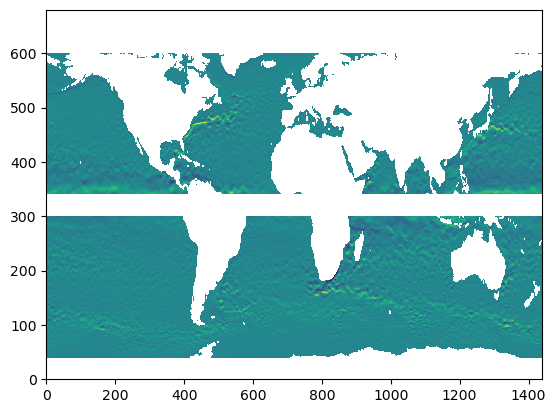

In [85]:
plt.pcolormesh(ds_maps.ugos[0])

In [ ]:

### FILTER ####
mask = np.load('/Odyssey/private/t22picar/2023a_SSH_mapping_OSE/nb_diags_THEO/uv_score_mask/mask_glorys_4th.npy')
mask = mask[np.newaxis,:,:]
mask = mask.repeat(365,axis=0)
ds_maps = ds_maps.where(mask, np.nan)

In [86]:
import os
path_file="/Odyssey/private/t22picar/multivar_uv/rec/duacs_geos_lucile"
# Chemin du dossier que vous souhaitez créer
dossier_path_daily = f'{path_file}/daily'
# Créer le dossier
os.makedirs(dossier_path_daily, exist_ok=True)


### SAVING ####
# Récupérer la liste des variables sans les dimensions
variables = [var for var in ds_maps.variables if var not in ds_maps.dims]
ds_maps,encoding = save(ds_maps,variables,dossier_path_daily)


#Select day per day 
from datetime import datetime, timedelta
# Définir la date de début et la date de fin
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 1, 1)

# Boucle sur chaque jour de la période
current_date = start_date
while current_date < end_date:
    #print(current_date.strftime('%Y-%m-%d'))  # Affiche la date au format AAAA-MM-JJ
    ds_map_day=ds_maps.sel(time=current_date)
    folder_out = dossier_path_daily+f"/unet_rec_{current_date.strftime('%Y-%m-%d')}.nc"
    ds_map_day.to_netcdf(folder_out, 'w', format="NETCDF4", encoding=encoding)
    current_date += timedelta(days=1)  # Passe au jour suivant


ugos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
vgos
{'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}
{'ugos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'vgos': {'zlib': True, 'complevel': 4, '_FillValue': 1e+20, 'dtype': 'float32'}, 'lon': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'lat': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}, 'time': {'zlib': True, 'complevel': 4, 'dtype': 'float32'}}


In [2]:
num_diff = 2  # Usual value is 2
num_centered = num_diff // 2

def compute_uvgeo(time_index):

    # 
    ssh = maps.zos.values[time_index,:]


    # Mask invalid SSH values
    ssh[abs(ssh) > 100] = numpy.nan

    # Initialize null matrices
    ugeo = numpy.full(numpy.shape(ssh), 0.)
    vgeo = numpy.full(numpy.shape(ssh), 0.)

    # Compute g/f
    goverf = constant_g / (constant_f0 * numpy.sin(numpy.deg2rad(lat2D)))

    # Compute derivatives
    dsshy = ssh[num_diff:, :] - ssh[:-num_diff, :]
    dsshx = ssh[:, num_diff:] - ssh[:, :-num_diff]
    dlonx = (
        (lon2D[:,num_diff:] - lon2D[:,:-num_diff])
        * numpy.cos(numpy.deg2rad(lat2D[:, num_centered:-num_centered]))
        * degtom
    )
    dlaty = (lat2D[num_diff:,:] - lat2D[:-num_diff,:]) * degtom

    # Compute geostrophic velocities
    ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
    vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx

    # Mask invalid values 
    #ugeo = numpy.ma.array(ugeo, mask=((abs(ugeo)>10)))
    #vgeo = numpy.ma.array(vgeo, mask=((abs(vgeo)>10)))

    #Mask close to the equator
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)<lat_mask)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<lat_mask)))

    #Mask high lat
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)>70)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<-70)))

    return(ugeo,vgeo)

In [3]:
maps

<xarray.Dataset> Size: 11GB
Dimensions:  (time: 366, lat: 680, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2020-01-01
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    zos      (time, lat, lon) float64 3GB ...
    sla      (time, lat, lon) float64 3GB ...
    ugos     (time, lat, lon) float64 3GB ...
    vgos     (time, lat, lon) float64 3GB ...
Attributes:
    comment:                   Sea Surface Height measured by Altimetry and d...
    source:                    Altimetry measurements
    Conventions:               CF-1.6
    history:                   2024-10-23 12:55:06Z: Creation
    references:                http://marine.copernicus.eu
    title:                     DT merged all satellites Global Ocean Gridded ...
    institution:               CLS, CNES
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1

In [ ]:
maps_ageo = maps.drop_vars("mlotst").drop_vars("zos").drop_vars("thetao")
maps_ageo

for time_index in range(3287):
    # Compute first time step
    (ugeo,vgeo) = compute_uvgeo(time_index) 

    uageo,vageo = maps.uo[time_index,:]-ugeo, maps.vo[time_index,:]-vgeo
    
    maps_ageo.uo.values[time_index] = uageo
    maps_ageo.vo.values[time_index] = vageo